#*WhereIsWaldo* Project - Step 2
##Author: Ernest Vereycken

### **read this before running the notebook**
- Be carefull when running cells multiple times, this may cause additional data to be added to a variable defined in a higher cell, this may cause incorrect results.
- Intermediate weights and parameters are temporarily stored in model.pth (and also read back in). If you start training again on a new data split (because of randomness) without removing the saved model.pth, the weights and parameters of the previous training will still be captured in the model.
- This is not the final version of Step 2. I will continue working on this once the model of step 1 is retrained.
- When things behave strangely, use 'Disconnect and delete runtime' and try again.
- If you get a cuda-related error, switch to cpu and run again, this will give you a more precise error message.

In [7]:
import os
import random
from tqdm import tqdm
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision.transforms.functional import to_pil_image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available

## First we define all classes from [**Step 1**](https://github.com/TentaTonny/WhereIsWaldo_Team18/blob/main/Pretraining_Triplet_Loss.ipynb). We need this to load pretrained model.

In [8]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, num_layers, heads, dropout):
        super().__init__()

        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout = dropout)
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.patchify(x)         # (batch_size, N, dim)
        x = x + self.pos_encoding    # (batch_size, N, dim)
        x = self.transformer(x)      # (batch_size, N, dim)
        x = x.mean(1)                # (batch_size, dim)
        x = self.classifier(x)
        return x

class Patchify(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_channels = 3,
                              out_channels = embed_dim,
                              kernel_size = patch_size,
                              stride = patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)   # (batch_size, dim, img_size // patch_size, img_size // patch_size)
        # the input to the transformer should be of shape (batch_size, num_patches, embedding dim)
         # (batch_size, dim, img_size // patch_size, img_size // patch_size) --> flattten --> (batch_size, dim, num_patches) --> tranpose --> (batch_size, num_patches, dim)
        x = x.flatten(2).transpose(1,2)
        return x

class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout = 0.):

        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class MultiHeadAttention(nn.Module):

    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)

        self.out_proj = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape

        x = self.norm(x)         # (B, N, C)

        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)

        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))

        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

## Preparing data


### Clone data directly into session.

**path:**    /content/Hey-Waldo/

**notes:**
- data will be deleted when you end session but you can just run this again.(this only takes a couple of seconds)
- you can also upload waldo data to drive but I think this is easier/cleaner

In [9]:
!cd '/content/'
!rm -rf '/content/Hey-Waldo/'
!git clone https://github.com/vc1492a/Hey-Waldo.git

Cloning into 'Hey-Waldo'...
remote: Enumerating objects: 18822, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 18822 (delta 6), reused 11 (delta 4), pack-reused 18808
Receiving objects: 100% (18822/18822), 112.66 MiB | 39.38 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (20840/20840), done.


### some auxiliary methods.

In [10]:
def show_tensor(t):
  plt.imshow(np.transpose(t, (1, 2, 0)))

def waldo_percentage(dataset):
  return round(dataset.count_waldos() / len(dataset.labels) * 100, 2)

### Create Dataset class for waldo data
#### we store image paths and their corresponding labels (0 if image does not contain waldo, 1 if image contains waldo)

In [11]:
class WaldoBinaryDataset(Dataset):
    def __init__(self, imgs=None, labels=None,  folder_paths=None, transform=None):
        self.imgs = []
        self.labels = []
        self.transform = transform
        self.augmentation = transforms.Compose([transforms.RandomRotation(degrees=30),  #random rotation between -30 and 30 degrees
                                                transforms.RandomHorizontalFlip(p=0.5),  #0.5 chance of horizontal flipping
                                                transforms.RandomAdjustSharpness(p=0.5, sharpness_factor=4),
                                                ])
        self.is_train = True #set this to false for testset and val set

        if folder_paths:
          #(reimplement later, kan cleaner)
          for folder_path in folder_paths:
              notwaldo_path = f'{folder_path}/notwaldo'
              waldo_path = f'{folder_path}/waldo'
              #first add images with waldo
              for filename in os.listdir(waldo_path):
                file_path = os.path.join(waldo_path, filename)
                self.imgs.append(file_path)
                self.labels.append(1)

              #add images without waldo
              for filename in os.listdir(notwaldo_path):
                  file_path = os.path.join(notwaldo_path, filename)
                  self.imgs.append(file_path)
                  self.labels.append(0)

          #shuffle_data
          self.shuffle_data()


    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image_path = self.imgs[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        #we only perform augmentation on waldos of train set
        if self.is_train and self.labels[idx] == 1:
          image = self.augmentation(image)

        return image, self.labels[idx]

    #shuffle imgs and labels (but preserve img-label relations)
    def shuffle_data(self):
        combined = list(zip(self.imgs, self.labels))
        random.shuffle(combined)
        self.imgs, self.labels = zip(*combined)
        self.imgs = list(self.imgs)
        self.labels = list(self.labels)

    def count_waldos(self):
      return sum(self.labels)


    #static method to create subset of dataset. x included, y excluded
    @staticmethod
    def create_subset_dataset(dataset, x, y):
        subset_imgs = dataset.imgs[x:y]
        subset_labels = dataset.labels[x:y]
        subset_dataset = WaldoBinaryDataset([], transform=dataset.transform)
        subset_dataset.imgs = subset_imgs
        subset_dataset.labels = subset_labels
        subset_dataset.waldo_count = sum(subset_labels)
        subset_dataset.notwaldo_count = len(subset_labels) - subset_dataset.waldo_count

        return subset_dataset

    @staticmethod
    def duplicate_waldos(dataset, duplicate_factor):
        duplicated_images = []
        duplicated_labels = []

        for i, img in enumerate(dataset.imgs):
            if dataset.labels[i] == 1:
                for _ in range(duplicate_factor):
                    duplicated_images.append(img)
                    duplicated_labels.append(1)

        #extend original lists with the duplicated images and labels
        dataset.imgs.extend(duplicated_images)
        dataset.labels.extend(duplicated_labels)
        #shuffle set again because all the added waldos are at the end of dataset.
        dataset.shuffle_data()

### Now let's load the dataset into memory

In [12]:
#if you use drive you should change paths here
folder_paths = ['/content/Hey-Waldo/128', '/content/Hey-Waldo/64']

#resize to 128x128
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

waldo_dataset = WaldoBinaryDataset(folder_paths=folder_paths, transform=transform)

### Split data into train-, validation- and testset

##### these ratios are defined in the assignment

In [13]:
train_ratio = 0.81
val_ratio = 0.09
test_ratio = 0.1

tolerance = 1e-10
#we add this tolerance because of rounding errors in floating point arithmetic
if not(abs(train_ratio + val_ratio + test_ratio - 1) < tolerance):
    raise Exception("invalid train/val/test ratios")

total_length = len(waldo_dataset)
train_boundary = int(train_ratio * total_length)
validation_boundary = int((train_ratio + val_ratio) * total_length)

#split in train test and val set
train_set = WaldoBinaryDataset.create_subset_dataset(waldo_dataset, 0, train_boundary)
val_set = WaldoBinaryDataset.create_subset_dataset(waldo_dataset, train_boundary, validation_boundary)
test_set = WaldoBinaryDataset.create_subset_dataset(waldo_dataset, validation_boundary, total_length)

#disable train on test and val
test_set.is_train = True
val_set.is_train = False

#some checks
print(f'TRAIN:\nlength: {len(train_set)}. \nTotal length: {total_length}. \npercentage: {round(len(train_set) / total_length * 100.0, 2)}\nwaldos: {train_set.count_waldos()}\nwaldo percentage: {waldo_percentage(train_set)}\n')
print(f'VALIDATION:\nlength: {len(val_set)}. \nTotal length: {total_length}. \npercentage: {round(len(val_set) / total_length * 100.0, 2)}\nwaldos: {val_set.count_waldos()}\nwaldo percentage: {waldo_percentage(val_set)}\n')
print(f'TEST:\nlength: {len(test_set)}. \nTotal length: {total_length}. \npercentage: {round(len(test_set) / total_length * 100.0, 2)}\nwaldos: {test_set.count_waldos()}\nwaldo percentage: {waldo_percentage(test_set)}\n')

TRAIN:
length: 5443. 
Total length: 6720. 
percentage: 81.0
waldos: 58
waldo percentage: 1.07

VALIDATION:
length: 605. 
Total length: 6720. 
percentage: 9.0
waldos: 4
waldo percentage: 0.66

TEST:
length: 672. 
Total length: 6720. 
percentage: 10.0
waldos: 4
waldo percentage: 0.6



### Imbalance and Augmentation
As you can see, the amount of images that contain waldo is only around 1% of the total amount. When I first trained the classification model, the model just predicted 0 for every input, which resulted in a very high accuracy. Ofcourse we don't want this so we will do some data augmentation to balance out the waldo/not waldo ratio.

In [14]:
#we duplicate every waldo n times.
duplicate_factor = 100
WaldoBinaryDataset.duplicate_waldos(train_set, duplicate_factor)

print(f'{waldo_percentage(train_set)}%')

52.1%


As we can see, the ratio is now somewhere around 50%. The problem now is that we got the exact same waldo image 100 times. To fix this we add some (random) transforms, in the \_\_getitem__() method. Now when we get images to feed to the model, the images are all slightly different. The following data augmentations are applied:

```
transforms.RandomRotation(degrees=30),  
transforms.RandomHorizontalFlip(p=0.5),  
transforms.RandomAdjustSharpness(p=0.5, sharpness_factor=4),
```


Let's look at this.

**note:** if the image does not contain waldo, the augmentation will not be applied. change n untill you get an image of waldo.

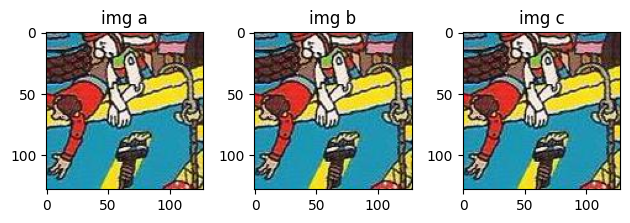

In [15]:
#get the nth image of the training set
n = 6

first_a = train_set.__getitem__(n)
first_b = train_set.__getitem__(n)
first_c = train_set.__getitem__(n)
img_a = first_a[0] #we only want the img (as tensor)
img_b = first_b[0]
img_c = first_c[0]

plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
plt.imshow(np.transpose(img_a, (1, 2, 0)))
plt.title('img a')

# Plotting the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
plt.imshow(np.transpose(img_b, (1, 2, 0)))
plt.title('img b')

# Plotting the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
plt.imshow(np.transpose(img_c, (1, 2, 0)))
plt.title('img c')

plt.tight_layout()
plt.show()

In [16]:
#creating DataLoader for each dataset
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False)

## Loading the pretained model
again, we could just upload the file to our drive our upload manually but I think this is easier. The github repository is public so it should work.
(if you do something similar in your own notebook, make sure you use the 'raw' URL)

In [17]:
!cd '/content/'
!rm model_128.pth_49
!wget https://github.com/TentaTonny/WhereIsWaldo_Team18/raw/main/models/model_128.pth_49

rm: cannot remove 'model_128.pth_49': No such file or directory
--2024-01-14 15:47:39--  https://github.com/TentaTonny/WhereIsWaldo_Team18/raw/main/models/model_128.pth_49
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TentaTonny/WhereIsWaldo_Team18/main/models/model_128.pth_49 [following]
--2024-01-14 15:47:39--  https://raw.githubusercontent.com/TentaTonny/WhereIsWaldo_Team18/main/models/model_128.pth_49
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39559867 (38M) [application/octet-stream]
Saving to: ‘model_128.pth_49’

model_128.pth_49    100%[===================>]  37.73M   185MB/s    in

#### We can now load the model by creating a ViT model and transfer the learned weights and parameters from the saved model

In [18]:
pretrained_model = ViT(image_size = 128,
            patch_size = 16,
            num_classes = 2,
            dim = 512,
            num_layers = 3,
            heads = 8,
            dropout = 0.1).to(device)

checkpoint = torch.load('/content/model_128.pth_49', map_location=device)
pretrained_model.load_state_dict(checkpoint['model'])
pretrained_model.to(device)

ViT(
  (patchify): Patchify(
    (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (transformer): Transformer(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x ModuleList(
        (0): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (keys): Linear(in_features=512, out_features=512, bias=True)
          (values): Linear(in_features=512, out_features=512, bias=True)
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=512, out_features=2048, bias=True)
            (2): ReLU()
            (3): Dropout(p=0.1, inplace=False)
            (4): Linear(i

## Check results of the pretrained model

### Plot the results of the pretrained model.

100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


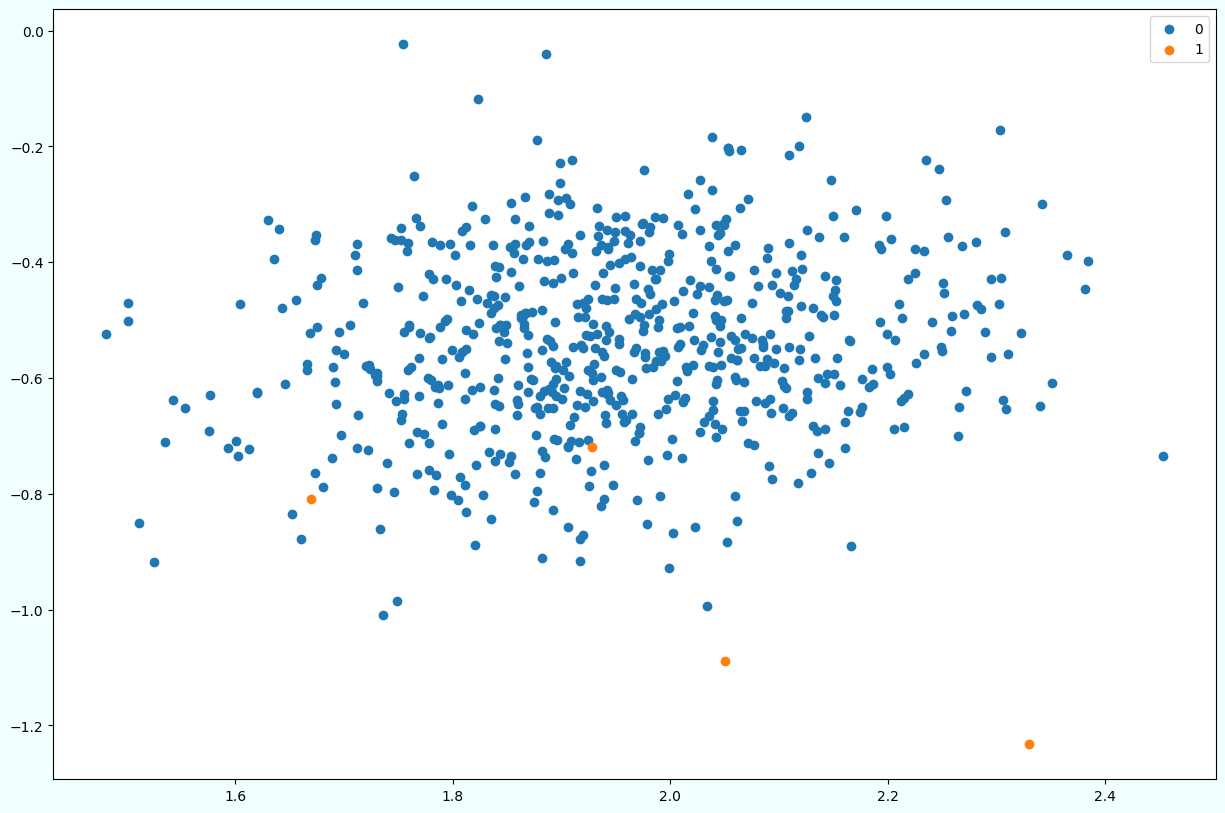

In [19]:
train_results = []
labels = []

pretrained_model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        train_results.append(pretrained_model(img.to(device)).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

### Now try this model on some augmented waldo's


<ipython-input-20-4c189a69b39c>:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,4, i+1) #2 rows, 4 columns


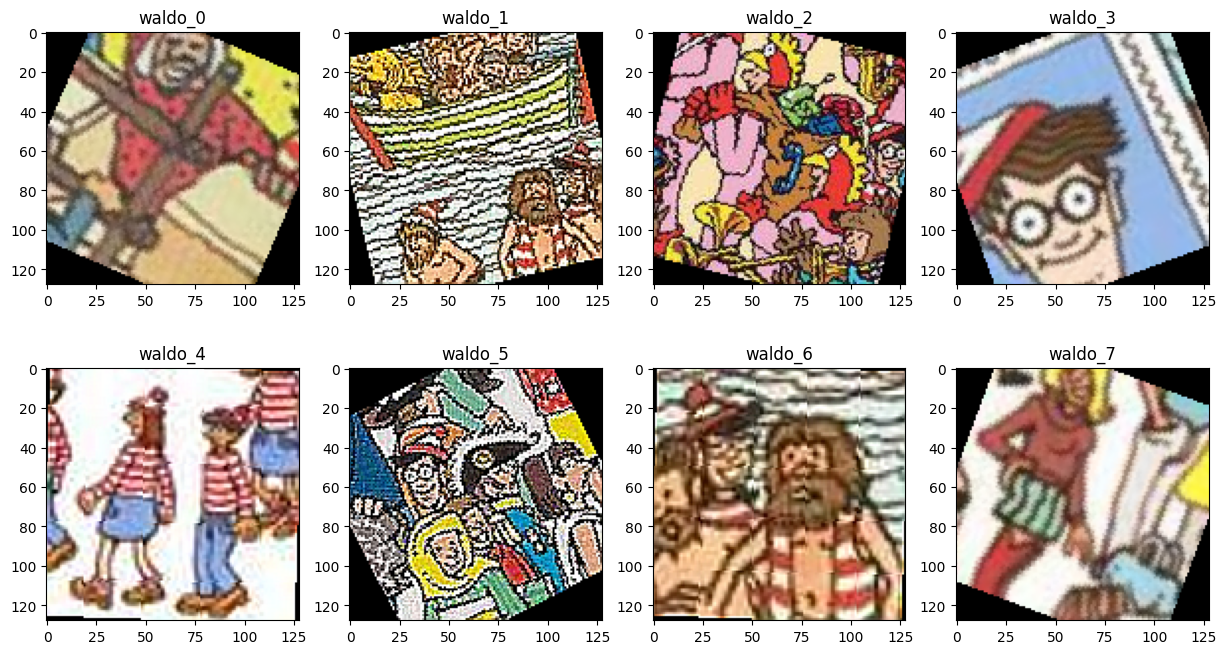

In [20]:
#get first n waldos of train set and show them
waldo_counter = 0
i = 0
waldo_imgs = []
n = 8

while waldo_counter < n:
    img, label = train_set.__getitem__(i)
    if label == 1:
        waldo_imgs.append(img)
        waldo_counter += 1
    i += 1


plt.figure(figsize=(15,8))
plt.axis('off')

#plot the waldo's (if you change n make sure to also change the rows and columns)
for i in range(n):
  plt.subplot(2,4, i+1) #2 rows, 4 columns
  plt.imshow(np.transpose(waldo_imgs[i], (1,2,0)))
  plt.title(f'waldo_{i}')

#### We now also plot results of the pretained model on the augmented waldo's.

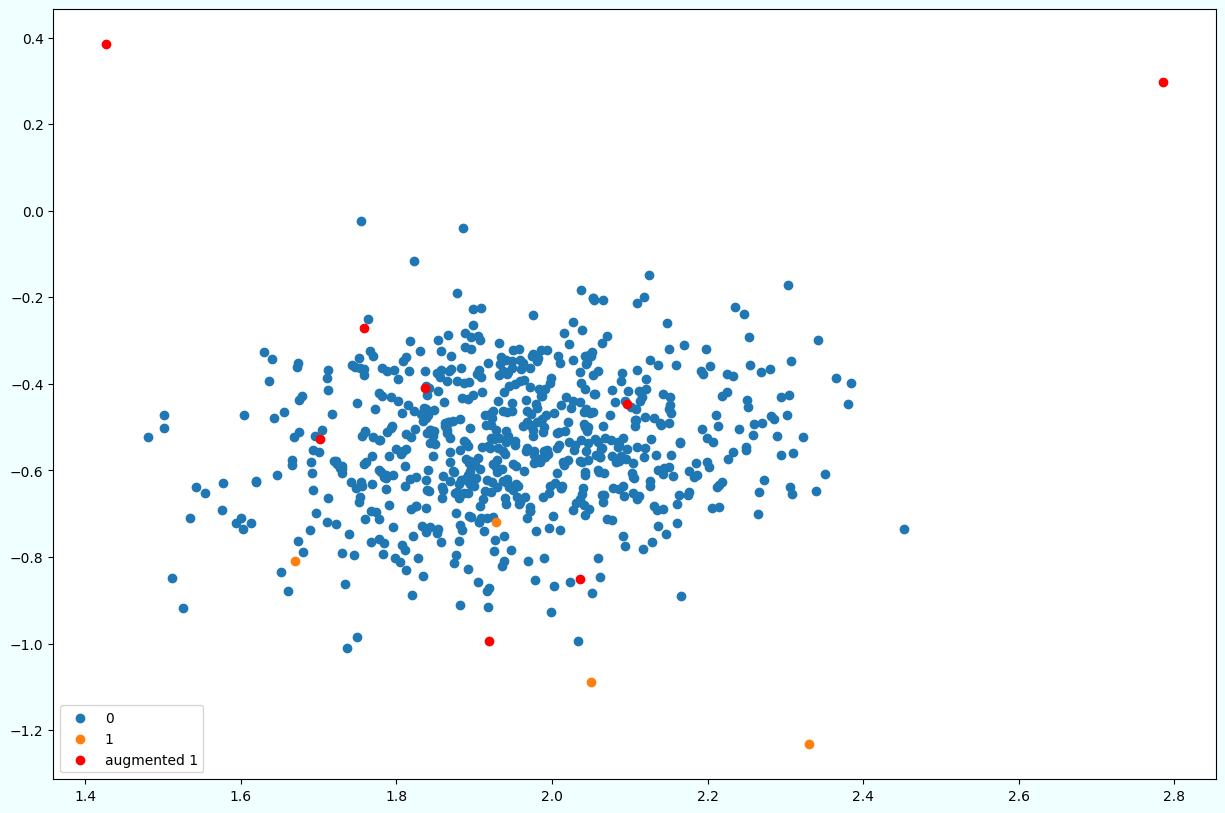

In [21]:
pretrained_results = []

pretrained_model.eval()
with torch.no_grad():
    for img in waldo_imgs:
        pretrained_results.append(pretrained_model(img.to(device).unsqueeze(0)).cpu().numpy())

results = [arr[0].tolist() for arr in pretrained_results]

plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

#add results of augmented waldo's
x_values, y_values = zip(*results)

plt.scatter(x_values, y_values, color='red',label='augmented 1')
plt.legend()
plt.show()

The model does not perform well on the augmented data. One possible cause is that the model is trained on all data and not just the train set. This will be solved later.

### Anton made a new model after this. We will now have a look at this.


In [22]:
!cd '/content/'
!rm model_final.pth_12
!wget https://github.com/TentaTonny/WhereIsWaldo_Team18/raw/main/models/model_final.pth_12

--2024-01-14 15:47:57--  https://github.com/TentaTonny/WhereIsWaldo_Team18/raw/main/models/model_final.pth_12
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TentaTonny/WhereIsWaldo_Team18/main/models/model_final.pth_12 [following]
--2024-01-14 15:47:57--  https://raw.githubusercontent.com/TentaTonny/WhereIsWaldo_Team18/main/models/model_final.pth_12
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39559867 (38M) [application/octet-stream]
Saving to: ‘model_final.pth_12’

model_final.pth_12  100%[===================>]  37.73M   183MB/s    in 0.2s    

2024-01-14 15:47:57 (183 MB/s) - ‘model_final

In [23]:
pretrained_model = ViT(image_size = 128,
            patch_size = 16,
            num_classes = 2,
            dim = 512,
            num_layers = 3,
            heads = 8,
            dropout = 0.1).to(device)

checkpoint = torch.load('/content/model_final.pth_12', map_location=device)
pretrained_model.load_state_dict(checkpoint['model'])
pretrained_model.to(device)

ViT(
  (patchify): Patchify(
    (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (transformer): Transformer(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x ModuleList(
        (0): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (keys): Linear(in_features=512, out_features=512, bias=True)
          (values): Linear(in_features=512, out_features=512, bias=True)
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=512, out_features=2048, bias=True)
            (2): ReLU()
            (3): Dropout(p=0.1, inplace=False)
            (4): Linear(i

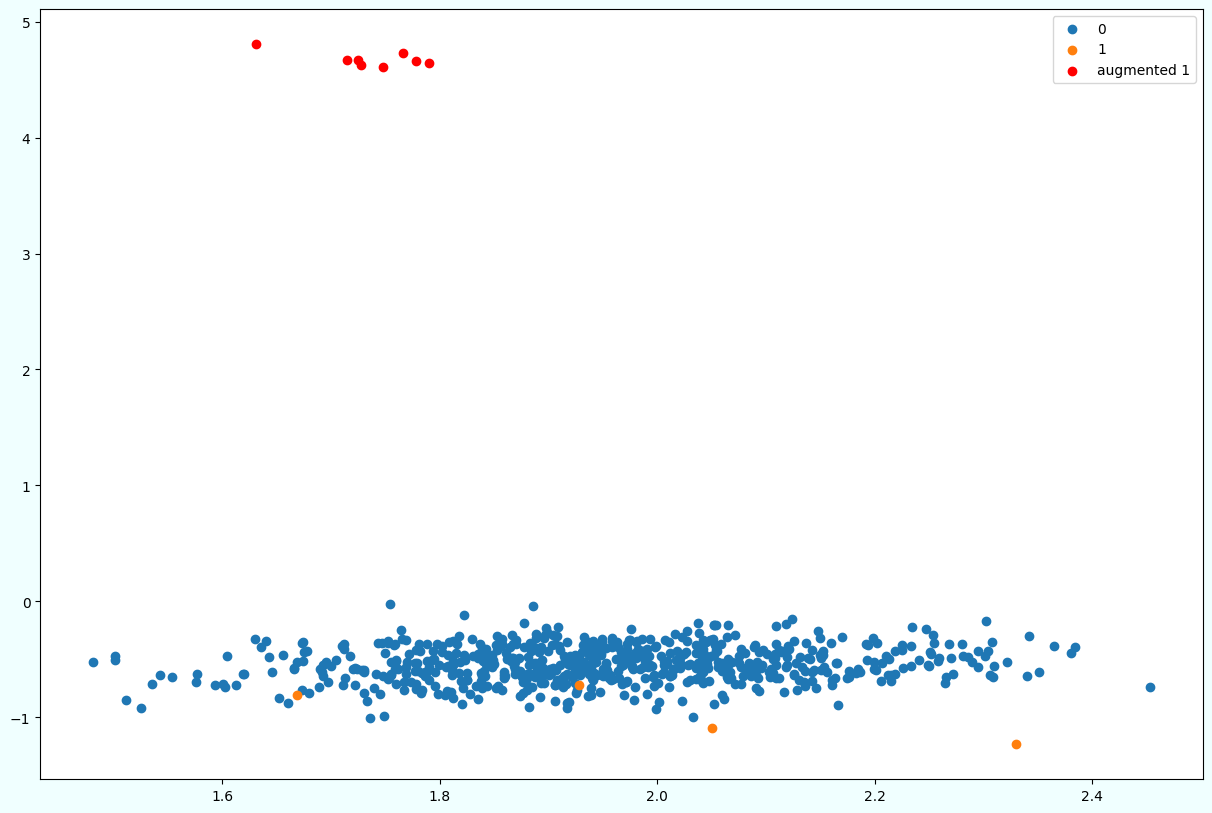

In [24]:
pretrained_results = []

pretrained_model.eval()
with torch.no_grad():
    for img in waldo_imgs:
        pretrained_results.append(pretrained_model(img.to(device).unsqueeze(0)).cpu().numpy())

results = [arr[0].tolist() for arr in pretrained_results]

plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

#add results of augmented waldo's
x_values, y_values = zip(*results)

plt.scatter(x_values, y_values, color='red',label='augmented 1')
plt.legend()
plt.show()

## Binary classification

In [25]:
class WaldoBinaryClassifier(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.pretrained = pretrained.to(device)  #pretrained transformer (with triple loss)
        self.pretrained.classifier = nn.Linear(pretrained.classifier.in_features, 1).to(device)

    def forward(self, x):
        return torch.sigmoid(self.pretrained(x))  #sigmoid activation for binary classification

In [26]:
binmodel = WaldoBinaryClassifier(pretrained_model)

### define training

In [27]:
learning_rate = 0.001

bin_epochs = 20
print_every = 20

bin_criterion = nn.BCELoss()  #cross entropy loss (binary)
bin_optimizer = torch.optim.Adam(binmodel.parameters(), lr=learning_rate)
#bin_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(bin_optimizer, T_max=bin_epochs)

def train(epoch):
    binmodel.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.float().unsqueeze(1)
        targets = targets.to(device)

        bin_optimizer.zero_grad()
        outputs = binmodel(inputs)
        loss = bin_criterion(outputs, targets)
        loss.backward()
        bin_optimizer.step()

        predictions = outputs.detach().cpu().numpy()
        predicted_labels = []
        #maybe I will write this cleaner later
        for p in predictions:
          if p[0] < 0.5:
            predicted_labels.append(0)
          else:
            predicted_labels.append(1)

        truth_labels = [1 if x.item() == 1 else 0 for row in targets for x in row]

        #count how much predictions are right
        count_equal = sum(a == b for a, b in zip(predicted_labels, truth_labels))

        train_loss += loss.item()

        total += targets.size(0)
        correct += count_equal

        epoch_loss = train_loss/(batch_idx+1)
        epoch_acc = 100.*(correct/total)

        if batch_idx % print_every == 0:
            print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch, bin_epochs, batch_idx, len(train_loader),
                                                                                   epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc


### define validation

In [28]:
def validate():
    binmodel.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(val_loader)):
            inputs = inputs.to(device)
            targets = targets.float().unsqueeze(1)
            targets = targets.to(device)
            outputs = binmodel(inputs)
            loss = bin_criterion(outputs, targets)

            predictions = outputs.detach().cpu().numpy()
            predicted_labels = []
            #loop cleaner schrijven
            for p in predictions:
                if p[0] < 0.5:
                    predicted_labels.append(0)
                else:
                    predicted_labels.append(1)

            truth_labels = [1 if x.item() == 1 else 0 for row in targets for x in row]

            #count how much predictions are right
            count_equal = sum(a == b for a, b in zip(predicted_labels, truth_labels))

            total += targets.size(0)
            correct += count_equal
            val_loss += loss.item()

    acc = 100.*(correct/total)
    loss = val_loss/(batch_idx+1)
    print('Validation Accuracy: {:.3f}, Validation Loss: {:.3f}'.format(acc, loss))
    return acc

#### start training/validation loop

In [29]:
best_acc = 0

losses = []
accuracies = []

for epoch in range(bin_epochs):
    epoch_loss, epoch_acc = train(epoch)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    #bin_scheduler.step()
    acc = validate()
    state = {'model': binmodel.state_dict(),
             'acc': acc,
             'epoch': epoch}
    if acc > best_acc:
        torch.save(state, 'model.pth')
        best_acc = acc

Epoch 0/20, Iter 0/88, Train Loss: 0.698, Train Accuracy: 50.000
Epoch 0/20, Iter 20/88, Train Loss: 0.191, Train Accuracy: 90.104
Epoch 0/20, Iter 40/88, Train Loss: 0.129, Train Accuracy: 94.245
Epoch 0/20, Iter 60/88, Train Loss: 0.102, Train Accuracy: 95.799
Epoch 0/20, Iter 80/88, Train Loss: 0.087, Train Accuracy: 96.634


100%|██████████| 7/7 [00:00<00:00, 10.29it/s]


Validation Accuracy: 99.339, Validation Loss: 0.037
Epoch 1/20, Iter 0/88, Train Loss: 0.039, Train Accuracy: 99.219
Epoch 1/20, Iter 20/88, Train Loss: 0.052, Train Accuracy: 98.958
Epoch 1/20, Iter 40/88, Train Loss: 0.042, Train Accuracy: 99.143
Epoch 1/20, Iter 60/88, Train Loss: 0.040, Train Accuracy: 99.193
Epoch 1/20, Iter 80/88, Train Loss: 0.039, Train Accuracy: 99.171


100%|██████████| 7/7 [00:00<00:00,  9.13it/s]


Validation Accuracy: 99.339, Validation Loss: 0.057
Epoch 2/20, Iter 0/88, Train Loss: 0.026, Train Accuracy: 100.000
Epoch 2/20, Iter 20/88, Train Loss: 0.032, Train Accuracy: 99.405
Epoch 2/20, Iter 40/88, Train Loss: 0.035, Train Accuracy: 99.295
Epoch 2/20, Iter 60/88, Train Loss: 0.041, Train Accuracy: 99.142
Epoch 2/20, Iter 80/88, Train Loss: 0.042, Train Accuracy: 99.132


100%|██████████| 7/7 [00:00<00:00, 10.81it/s]


Validation Accuracy: 99.008, Validation Loss: 0.057
Epoch 3/20, Iter 0/88, Train Loss: 0.038, Train Accuracy: 99.219
Epoch 3/20, Iter 20/88, Train Loss: 0.039, Train Accuracy: 99.182
Epoch 3/20, Iter 40/88, Train Loss: 0.038, Train Accuracy: 99.219
Epoch 3/20, Iter 60/88, Train Loss: 0.038, Train Accuracy: 99.219
Epoch 3/20, Iter 80/88, Train Loss: 0.038, Train Accuracy: 99.238


100%|██████████| 7/7 [00:00<00:00,  8.41it/s]


Validation Accuracy: 99.339, Validation Loss: 0.041
Epoch 4/20, Iter 0/88, Train Loss: 0.057, Train Accuracy: 98.438
Epoch 4/20, Iter 20/88, Train Loss: 0.045, Train Accuracy: 98.921
Epoch 4/20, Iter 40/88, Train Loss: 0.044, Train Accuracy: 99.028
Epoch 4/20, Iter 60/88, Train Loss: 0.043, Train Accuracy: 99.052
Epoch 4/20, Iter 80/88, Train Loss: 0.045, Train Accuracy: 99.007


100%|██████████| 7/7 [00:00<00:00, 10.43it/s]


Validation Accuracy: 99.339, Validation Loss: 0.043
Epoch 5/20, Iter 0/88, Train Loss: 0.107, Train Accuracy: 97.656
Epoch 5/20, Iter 20/88, Train Loss: 0.040, Train Accuracy: 99.107
Epoch 5/20, Iter 40/88, Train Loss: 0.038, Train Accuracy: 99.143
Epoch 5/20, Iter 60/88, Train Loss: 0.035, Train Accuracy: 99.257
Epoch 5/20, Iter 80/88, Train Loss: 0.036, Train Accuracy: 99.228


100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


Validation Accuracy: 99.339, Validation Loss: 0.035
Epoch 6/20, Iter 0/88, Train Loss: 0.034, Train Accuracy: 99.219
Epoch 6/20, Iter 20/88, Train Loss: 0.034, Train Accuracy: 99.293
Epoch 6/20, Iter 40/88, Train Loss: 0.044, Train Accuracy: 99.009
Epoch 6/20, Iter 60/88, Train Loss: 0.047, Train Accuracy: 98.975
Epoch 6/20, Iter 80/88, Train Loss: 0.046, Train Accuracy: 98.997


100%|██████████| 7/7 [00:00<00:00, 10.52it/s]


Validation Accuracy: 99.339, Validation Loss: 0.035
Epoch 7/20, Iter 0/88, Train Loss: 0.053, Train Accuracy: 98.438
Epoch 7/20, Iter 20/88, Train Loss: 0.045, Train Accuracy: 99.033
Epoch 7/20, Iter 40/88, Train Loss: 0.038, Train Accuracy: 99.181
Epoch 7/20, Iter 60/88, Train Loss: 0.039, Train Accuracy: 99.155
Epoch 7/20, Iter 80/88, Train Loss: 0.041, Train Accuracy: 99.093


100%|██████████| 7/7 [00:00<00:00, 10.52it/s]


Validation Accuracy: 99.339, Validation Loss: 0.036
Epoch 8/20, Iter 0/88, Train Loss: 0.078, Train Accuracy: 97.656
Epoch 8/20, Iter 20/88, Train Loss: 0.035, Train Accuracy: 99.330
Epoch 8/20, Iter 40/88, Train Loss: 0.038, Train Accuracy: 99.238
Epoch 8/20, Iter 60/88, Train Loss: 0.039, Train Accuracy: 99.206
Epoch 8/20, Iter 80/88, Train Loss: 0.039, Train Accuracy: 99.171


100%|██████████| 7/7 [00:00<00:00, 10.11it/s]


Validation Accuracy: 99.339, Validation Loss: 0.034
Epoch 9/20, Iter 0/88, Train Loss: 0.004, Train Accuracy: 100.000
Epoch 9/20, Iter 20/88, Train Loss: 0.037, Train Accuracy: 99.219
Epoch 9/20, Iter 40/88, Train Loss: 0.039, Train Accuracy: 99.200
Epoch 9/20, Iter 60/88, Train Loss: 0.034, Train Accuracy: 99.334
Epoch 9/20, Iter 80/88, Train Loss: 0.034, Train Accuracy: 99.325


100%|██████████| 7/7 [00:00<00:00, 10.55it/s]


Validation Accuracy: 99.174, Validation Loss: 0.043
Epoch 10/20, Iter 0/88, Train Loss: 0.083, Train Accuracy: 97.656
Epoch 10/20, Iter 20/88, Train Loss: 0.044, Train Accuracy: 99.070
Epoch 10/20, Iter 40/88, Train Loss: 0.043, Train Accuracy: 99.085
Epoch 10/20, Iter 60/88, Train Loss: 0.040, Train Accuracy: 99.168
Epoch 10/20, Iter 80/88, Train Loss: 0.038, Train Accuracy: 99.209


100%|██████████| 7/7 [00:00<00:00, 10.75it/s]


Validation Accuracy: 99.339, Validation Loss: 0.034
Epoch 11/20, Iter 0/88, Train Loss: 0.005, Train Accuracy: 100.000
Epoch 11/20, Iter 20/88, Train Loss: 0.038, Train Accuracy: 99.070
Epoch 11/20, Iter 40/88, Train Loss: 0.041, Train Accuracy: 99.085
Epoch 11/20, Iter 60/88, Train Loss: 0.035, Train Accuracy: 99.244
Epoch 11/20, Iter 80/88, Train Loss: 0.035, Train Accuracy: 99.248


100%|██████████| 7/7 [00:00<00:00, 10.65it/s]


Validation Accuracy: 99.339, Validation Loss: 0.035
Epoch 12/20, Iter 0/88, Train Loss: 0.004, Train Accuracy: 100.000
Epoch 12/20, Iter 20/88, Train Loss: 0.034, Train Accuracy: 99.256
Epoch 12/20, Iter 40/88, Train Loss: 0.035, Train Accuracy: 99.257
Epoch 12/20, Iter 60/88, Train Loss: 0.036, Train Accuracy: 99.257
Epoch 12/20, Iter 80/88, Train Loss: 0.036, Train Accuracy: 99.267


100%|██████████| 7/7 [00:00<00:00, 10.68it/s]


Validation Accuracy: 99.339, Validation Loss: 0.034
Epoch 13/20, Iter 0/88, Train Loss: 0.065, Train Accuracy: 98.438
Epoch 13/20, Iter 20/88, Train Loss: 0.031, Train Accuracy: 99.293
Epoch 13/20, Iter 40/88, Train Loss: 0.032, Train Accuracy: 99.276
Epoch 13/20, Iter 60/88, Train Loss: 0.032, Train Accuracy: 99.257
Epoch 13/20, Iter 80/88, Train Loss: 0.031, Train Accuracy: 99.286


100%|██████████| 7/7 [00:00<00:00, 10.45it/s]


Validation Accuracy: 99.174, Validation Loss: 0.041
Epoch 14/20, Iter 0/88, Train Loss: 0.004, Train Accuracy: 100.000
Epoch 14/20, Iter 20/88, Train Loss: 0.023, Train Accuracy: 99.516
Epoch 14/20, Iter 40/88, Train Loss: 0.026, Train Accuracy: 99.447
Epoch 14/20, Iter 60/88, Train Loss: 0.031, Train Accuracy: 99.334
Epoch 14/20, Iter 80/88, Train Loss: 0.032, Train Accuracy: 99.286


100%|██████████| 7/7 [00:00<00:00, 10.56it/s]


Validation Accuracy: 99.339, Validation Loss: 0.033
Epoch 15/20, Iter 0/88, Train Loss: 0.012, Train Accuracy: 100.000
Epoch 15/20, Iter 20/88, Train Loss: 0.043, Train Accuracy: 98.884
Epoch 15/20, Iter 40/88, Train Loss: 0.047, Train Accuracy: 98.952
Epoch 15/20, Iter 60/88, Train Loss: 0.049, Train Accuracy: 98.911
Epoch 15/20, Iter 80/88, Train Loss: 0.047, Train Accuracy: 98.958


100%|██████████| 7/7 [00:00<00:00, 10.47it/s]


Validation Accuracy: 99.174, Validation Loss: 0.043
Epoch 16/20, Iter 0/88, Train Loss: 0.048, Train Accuracy: 98.438
Epoch 16/20, Iter 20/88, Train Loss: 0.036, Train Accuracy: 99.219
Epoch 16/20, Iter 40/88, Train Loss: 0.036, Train Accuracy: 99.123
Epoch 16/20, Iter 60/88, Train Loss: 0.046, Train Accuracy: 98.899
Epoch 16/20, Iter 80/88, Train Loss: 0.045, Train Accuracy: 98.939


100%|██████████| 7/7 [00:00<00:00, 10.32it/s]


Validation Accuracy: 99.008, Validation Loss: 0.060
Epoch 17/20, Iter 0/88, Train Loss: 0.018, Train Accuracy: 100.000
Epoch 17/20, Iter 20/88, Train Loss: 0.033, Train Accuracy: 99.405
Epoch 17/20, Iter 40/88, Train Loss: 0.032, Train Accuracy: 99.371
Epoch 17/20, Iter 60/88, Train Loss: 0.037, Train Accuracy: 99.244
Epoch 17/20, Iter 80/88, Train Loss: 0.037, Train Accuracy: 99.238


100%|██████████| 7/7 [00:00<00:00, 10.42it/s]


Validation Accuracy: 99.339, Validation Loss: 0.039
Epoch 18/20, Iter 0/88, Train Loss: 0.007, Train Accuracy: 100.000
Epoch 18/20, Iter 20/88, Train Loss: 0.041, Train Accuracy: 99.033
Epoch 18/20, Iter 40/88, Train Loss: 0.044, Train Accuracy: 98.952
Epoch 18/20, Iter 60/88, Train Loss: 0.041, Train Accuracy: 99.078
Epoch 18/20, Iter 80/88, Train Loss: 0.041, Train Accuracy: 99.084


100%|██████████| 7/7 [00:00<00:00, 10.53it/s]


Validation Accuracy: 99.174, Validation Loss: 0.047
Epoch 19/20, Iter 0/88, Train Loss: 0.086, Train Accuracy: 97.656
Epoch 19/20, Iter 20/88, Train Loss: 0.037, Train Accuracy: 99.182
Epoch 19/20, Iter 40/88, Train Loss: 0.037, Train Accuracy: 99.181
Epoch 19/20, Iter 60/88, Train Loss: 0.034, Train Accuracy: 99.296
Epoch 19/20, Iter 80/88, Train Loss: 0.035, Train Accuracy: 99.257


100%|██████████| 7/7 [00:00<00:00, 10.44it/s]

Validation Accuracy: 99.008, Validation Loss: 0.050


#### testing (after the model is trained)

In [2]:
def test():
    binmodel.eval()

    results = []
    truth_labels = []


    with torch.no_grad():
        for img, label in tqdm(test_loader):
            results.append(binmodel(img.to(device)).cpu().numpy())
            truth_labels.append(label)

    predicted_labels = []
    #note: I've set the batch_size for testing to 1, if you change this, the code below will no longer work
    for batch in results:
        for res in batch:
            predicted_labels.append(round(res[0]))

    truth_labels = test_loader.dataset.labels
    err_idxs = []
    correct = 0
    correct_waldo = 0
    test_len = len(truth_labels)
    for i in range(test_len):
        if predicted_labels[i] == 1 and truth_labels[i] == 1:
          correct_waldo += 1
        if predicted_labels[i] == truth_labels[i]:
            correct += 1
        else:
            err_idxs.append(i)

    print(f'\naccuracy on test set: {round(correct/test_len, 3)}\n')


test()


NameError: name 'binmodel' is not defined